In [3]:
from __future__ import print_function
# Connect to Elastic Cloud
from elasticsearch import Elasticsearch
from elasticsearch import helpers
import urllib3
urllib3.disable_warnings()
import pickle
import datetime
import numpy as np


es = Elasticsearch(
    ['https://86dd17d952698a0f90485f28a0087669.eu-west-1.aws.found.io'],
    port=9243,
    http_auth='elastic:9X4hmUZXasOBuF49ujcGBqLS',
    verify_certs=False
)

es.count(index='events', doc_type='batch2')

/root/anaconda3/lib/python3.6/site-packages/elasticsearch/connection/http_urllib3.py:90: UserWarning: Connecting to 86dd17d952698a0f90485f28a0087669.eu-west-1.aws.found.io using SSL with verify_certs=False is insecure.
  'Connecting to %s using SSL with verify_certs=False is insecure.' % host)


{'_shards': {'failed': 0, 'successful': 5, 'total': 5}, 'count': 2000000}

In [5]:
''' 
Download data to avoid unnecessary download in the future
'''
import copy

gen = helpers.scan(es,
    query={"query": {"match_all": {}}},
    index="events",
    doc_type="batch2"
)

# Iterate through all record
i = 0
events_start = []
events_end = []
for event in gen:
    if i % 10000 == 0:
            print('.', end='')
    i += 1
    #print(event)
    single_event = {
        "event_type": event['_source']['event_type'],
        "uuid": event['_source']['uuid'],
        "bytes": event['_source']['bytes'],
        "timestamp": event['_source']['timestamp'] 
    }
    
    if event['_source']['event_type'] == 'transfer-queued':
        events_start.append(copy.deepcopy(single_event))
    else:
        events_end.append(copy.deepcopy(single_event))
print("Done!")


........................................................................................................................................................................................................Done!


In [20]:
''' 
Pre-process data

Generate a data metrix of size 950000(approx.) x 2 --> [Num of successful transfer] x [Filesize, Duration]
'''


events_start_sorted = sorted(events_start, key=lambda e: e['uuid'], reverse=True)
events_end_sorted = sorted(events_end, key=lambda e: e['uuid'], reverse=True)

succ_num = 0
for i in range(0,len(events_end)):
    if events_end[i]['event_type'] == 'transfer-success':
        succ_num += 1
        
size_time = np.zeros((succ_num,2), dtype=np.int)
succ_index = 0
for i in range(0,len(events_start_sorted)):
    # Skip 'failed'
    if events_end_sorted[i]['event_type'] == 'transfer-failed':
        continue
        
    start_time = datetime.datetime.strptime(events_start_sorted[i]['timestamp'], "%Y-%m-%dT%H:%M:%S")
    end_time = datetime.datetime.strptime(events_end_sorted[i]['timestamp'], "%Y-%m-%dT%H:%M:%S")
    duration = end_time - start_time
    
    size_time[succ_index][0] = int(events_start_sorted[i]['bytes'])
    size_time[succ_index][1] = int(duration.total_seconds())
    
    succ_index += 1
    
with open('data_size_time.bin','wb') as f:
    pickle.dump(size_time, f)


In [4]:
'''
Get data and prepare training and testing set
'''

with open('data_size_time.bin','rb') as f:
    data = pickle.load(f)
    
np.random.shuffle(data)

train_size = int(data.shape[0] * 0.8)
test_size = data.shape[0] - train_size

train_data = data[:train_size]
test_data = data[train_size:]

In [5]:
'''
Normalise/Standardis the data
'''
from sklearn import preprocessing

norm_train_f = train_data[:,0] / 100000.0
norm_test_f = test_data[:,0] / 100000.0

norm_train_i = norm_train_f.astype(int)
norm_test_i = norm_test_f.astype(int)

# train_input = norm_train_i
# test_input = norm_test_i

train_input = preprocessing.scale(norm_train_i.astype(float).reshape(-1, 1))
test_input = preprocessing.scale(norm_test_i.astype(float).reshape(-1, 1))

train_label = train_data[:,1]
test_label = test_data[:,1]

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential([
    Dense(1, input_dim=1),
    Activation('linear'),
    Dense(1),
    Activation('linear')
])

# For a mean squared error regression problem
model.compile(optimizer='rmsprop',
              loss='mse')

# Disable progress bar, since it breaks the connection between Jupyter and server
print("Start fitting the training data")
model.fit(train_input, train_label, epochs=3, batch_size=32, verbose=2)
print("Evaluating the model with training data")
train_score = model.evaluate(train_input, train_label, batch_size=32, verbose=0)
print("Training score: ", train_score)

print("Evaluating the model with testing data")
test_score = model.evaluate(test_input, test_label, batch_size=32, verbose=0)
print("Testing score: ", test_score)

Using TensorFlow backend.


Start fitting the training data
Epoch 1/3
49s - loss: 705856.4337
Epoch 2/3
50s - loss: 3834.8911
Epoch 3/3
50s - loss: 0.0865
Evaluating the model with training data
Training score:  0.0874762733315
Evaluating the model with testing data
Testing score:  0.157898791055


### Experiment with model sitting

1. Experiment 1

   * Data input: 

         Integer, original filesize in Bytes divided by 100000 then only take the remaining integer as the training input, in order to minimise the computation complexity
    
   * Model structure:
   
         Hidden layer 1 - with input size 1, output size 1, linear activated
         Output layer   - output size 1, linear activated
    
         Loss function: means square error
    
   * Training setting:
   
         Epochs = 3
     
   * Results:
   
         Start fitting the training data
         Epoch 1/3
         48s - loss: 10635500.0291
         Epoch 2/3
         48s - loss: 63.2363
         Epoch 3/3
         46s - loss: 64.6800
         Evaluating the model with training data
         Training score:  1.054810227
         Evaluating the model with testing data
         Testing score:  1.0532055147
     
2. Experiment 2
   
   * Data input: 

         Integer, original filesize in Bytes 
    
   * Model structure:
   
         Hidden layer 1 - with input size 1, output size 1, linear activated
         Output layer   - output size 1, linear activated
    
         Loss function: means square error
    
   * Training setting:
   
         Epochs = 3
     
   * Results:
   
         Start fitting the training data
         Epoch 1/3
         47s - loss: 476697904767733.8125
         Epoch 2/3
         45s - loss: 13069298611147.6738
         Epoch 3/3
         42s - loss: 202855715356.0633
         Evaluating the model with training data
         Training score:  1418203.36609
         Evaluating the model with testing data
         Testing score:  1416659.76076
         
3. Experiment 3
   
   * Data input: 

         Integer, original filesize in Bytes divided by 100000 then standardised around 0, in order to minimise the computation complexity, which might provide higher accuracy and speed up training
    
   * Model structure:
   
         Hidden layer 1 - with input size 1, output size 1, linear activated
         Output layer   - output size 1, linear activated
    
         Loss function: means square error
    
   * Training setting:
   
         Epochs = 3
     
   * Results:
   
         Start fitting the training data
         Epoch 1/3
         43s - loss: 746156.8748
         Epoch 2/3
         49s - loss: 5985.8051
         Epoch 3/3
         46s - loss: 0.0866
         Evaluating the model with training data
         Training score:  0.0866609521621
         Evaluating the model with testing data
         Testing score:  0.575349398989
         
4. Experiment 4
   
   * Data input: 

         Integer, original filesize in Bytes divided by 100000 then standardised around 0, in order to minimise the computation complexity, which might provide higher accuracy and speed up training
    
   * Model structure:
   
         Hidden layer 1 - with input size 1, output size 1, linear activated
         Output layer   - output size 1, linear activated
    
         Loss function: means square error
    
   * Training setting:
   
         Epochs = 5
     
   * Results:
   
         Start fitting the training data
         Epoch 1/5
         43s - loss: 734530.0496
         Epoch 2/5
         43s - loss: 5452.6346
         Epoch 3/5
         41s - loss: 0.0866
         Epoch 4/5
         43s - loss: 0.0866
         Epoch 5/5
         43s - loss: 0.0866
         Evaluating the model with training data
         Training score:  0.0963083258779
         Evaluating the model with testing data
         Testing score:  0.419407293773
         
### Conclusion on experiment

Since this is a regression problem, not a classification problem, and the output range is 0 to large positive, lots of the activation function are inapplicable. Linear activation function is a reasonable choice. Also, mean squared error as loss function is a trandictional way to do regression. 

Experiment 3 and 4 have the best result, because they have the lowest mean square error for testing data set, which is around 0.5
         
The model I chose at the end is the one used in experiment 3

In regression problems, to use mean squared error to evaluated the model is more appropriate    

**Training score:  0.0866609521621**

**Testing score:  0.575349398989**

In [16]:
# Get the predicted result from ecperiment 3 model setting 
train_pred = model.predict(train_input, batch_size=32, verbose=0)

In [7]:
# Get the predicted result from ecperiment 3 model setting 
test_pred = model.predict(test_input, batch_size=32, verbose=0)

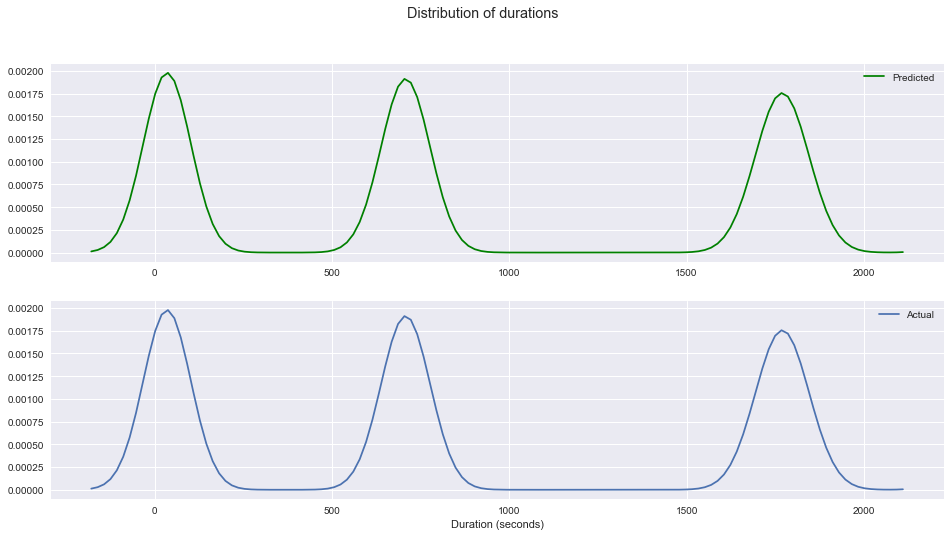

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={"figure.figsize": (16, 8)})
fig = plt.figure(1)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
sns.distplot(test_pred, hist=False, kde=True, rug=False, ax=ax1, color="g",label="Predicted")
sns.distplot(test_label, hist=False, kde=True, rug=False, ax=ax2, label="Actual")
plt.xlabel("Duration (seconds)")
fig.suptitle('Distribution of durations')


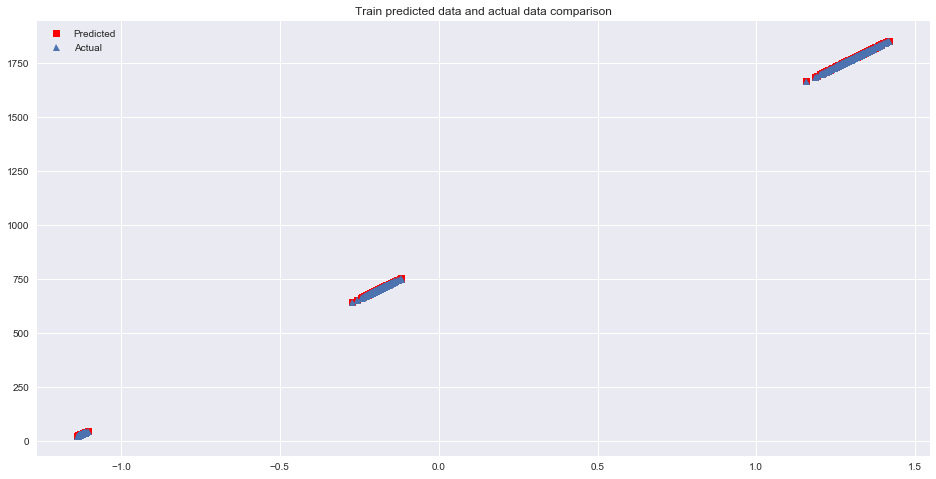

In [20]:
plt.plot(train_input[:1000], train_pred[:1000], 'rs', label="Predicted")
plt.plot(train_input[:1000], train_label[:1000], '^', label="Actual")
plt.title("Train predicted data and actual data comparison")
plt.legend()

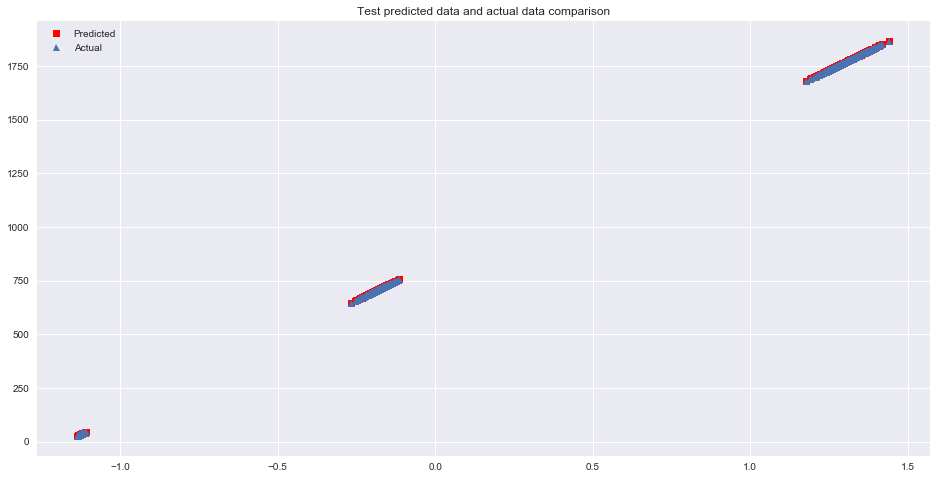

In [21]:
plt.plot(test_input[:1000], test_pred[:1000], 'rs', label="Predicted")
plt.plot(test_input[:1000], test_label[:1000], '^', label="Actual")
plt.title("Test predicted data and actual data comparison")
plt.legend()

### Comment on the model (Why and How it works)

From the graph above, it's quite obvious that the model approximates the original generator. The predicted results generated by the model from test set has almost the identical distribution as the actual duration produced by the generator. Also, the score calculated from test set is around 0.5, which is the mean squared error for the predicted value and the actual value, it means the deviation of the predicted value from the standard value is pretty small.

In my generator, the duration of a transmission has linear relation with the filesize(i.e. duration = filesize * k, k>0). Since I am using linear activation function, and mse as the loss function, network will try to match the linear function in the activation function to the one I used in my generator, however, I normalised the input data before putting them into the model, which means that it's almost impossible to find the original k, therefore the score on training set is not zeros.

The way the model was trained is similar to linear regression problem.